In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("C:\\Users\\Aliff\\OneDrive - siswa.um.edu.my\\Sem 7\\Image Processing\\Assignments\\Face-Mask-Detection\\dataset"))
data = []
labels = []


[INFO] loading images...


In [4]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

c:\users\aliff\onedri~1.my\sem7~1\imagep~1\assign~1\test\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))

c:\users\aliff\onedri~1.my\sem7~1\imagep~1\assign~1\test\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [9]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [10]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] training head...
Train for 96 steps, validate on 773 samples
Epoch 1/20
96/96 [==============================] - 319s 3s/step - loss: 0.5470 - accuracy: 0.7209 - val_loss: 0.4408 - val_accuracy: 0.7956
Epoch 2/20
96/96 [==============================] - 299s 3s/step - loss: 0.3085 - accuracy: 0.8758 - val_loss: 0.3758 - val_accuracy: 0.8255
Epoch 3/20
96/96 [==============================] - 285s 3s/step - loss: 0.2347 - accuracy: 0.9078 - val_loss: 0.3501 - val_accuracy: 0.8424
Epoch 4/20
96/96 [==============================] - 302s 3s/step - loss: 0.2007 - accuracy: 0.9324 - val_loss: 0.3022 - val_accuracy: 0.8724
Epoch 5/20
96/96 [==============================] - 324s 3s/step - loss: 0.1687 - accuracy: 0.9340 - val_loss: 0.3074 - val_accuracy: 0.8737
Epoch 6/20
96/96 [==============================] - 334s 3s/step - loss: 0.1643 - accuracy: 0.9337 - val_loss: 0.2567 - val_accuracy: 0.8945
Epoch 7/20
96/96 [==============================] - 345s 4s/step - loss: 0.1471 - accu

In [15]:
lb.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

In [33]:
from sklearn.metrics import confusion_matrix
a = confusion_matrix(testY.argmax(axis=1), predIdxs)

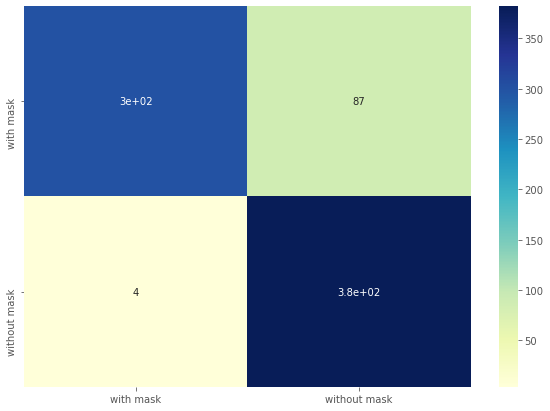

In [36]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[300,  87],
       [  4, 382]]

df_cm = pd.DataFrame(array, index = [i for i in ["with mask",'without mask']],
                  columns = [i for i in ["with mask",'without mask']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")
plt.savefig("cf.png")

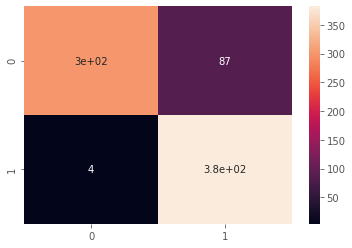

In [34]:
sn.heatmap(a, annot=True)

In [27]:
(300 + 382) / ((300+4)+(382+87))

0.8822768434670116

In [14]:
testY.argmax(axis=1)

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,

In [12]:
predIdxs

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("C:\\Users\\Aliff\\OneDrive - siswa.um.edu.my\\Sem 7\\Image Processing\\Assignments\\Face-Mask-Detection\\new_model.h5", save_format="h5")

In [22]:
H.history.items()

dict_items([('loss', [0.5472685989211588, 0.3078716155360727, 0.2345457685539146, 0.20035536519063066, 0.16852082756220127, 0.16413981708046657, 0.14682602368149103, 0.12726571197603262, 0.13481224981787937, 0.12717970500584522, 0.1122668905682813, 0.10217499185621348, 0.11630502074372534, 0.1047873557977427, 0.09726753999399983, 0.09007573189104305, 0.09740126496241763, 0.09676444235385633, 0.09332285737192708, 0.09196890329613405]), ('accuracy', [0.720915, 0.875817, 0.9078431, 0.93235296, 0.9339869, 0.93366015, 0.9457516, 0.9545752, 0.9519608, 0.951634, 0.9575163, 0.9630719, 0.9617647, 0.9617647, 0.9643791, 0.9679738, 0.96830064, 0.96535945, 0.9660131, 0.96830064]), ('val_loss', [0.440769484866637, 0.37575632541947657, 0.35011401213464577, 0.3021569366134308, 0.3074056056616069, 0.256671780910714, 0.2462881925343542, 0.28817220415828454, 0.2580394419476409, 0.2680534145193606, 0.2886287649421149, 0.21115893029148797, 0.3102094969804969, 0.3474818118022608, 0.32778120341615563, 0.2671

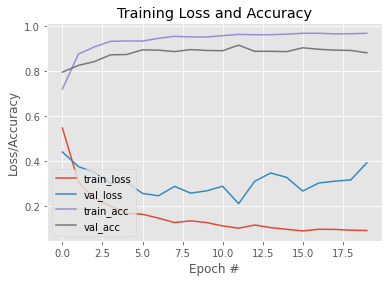

In [26]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("training.png")